# Homework 3, Problem 2

- File Names and Directory Structure: Logfile and image directory is created in the current working directory. 
- Hypter Parameters
    -   Specifically set the **num_components** to 0 if you want to generate the graph from the beginning or alternatively set it to 783 if you want to see the results with all 784 dimensions, and
    -   Select the **USE_FASHION_MNIST** Flag for selecting between MNIST and FASHION_MNIST
    -   goal specifies whether we want to achieve 95% or 99% accuracy


**Simple Haar Filters for MNIST/FMNIST Features:** In this problem, you will use a
simple feature extraction method on MNIST/FMNIST and perform least-squares classification
on the obtained features – i.e., without using the original images. Each image in these
datasets is (28×28) and from each of these, you will extract four (14×14) images. As done in
lecture, we refer to the four images obtained as LL, LH, HL, and HH, where L is for low-pass
and H is for high-pass.

### import libraries

In [97]:
import numpy as np 
import matplotlib.pyplot as plt
from torchvision import datasets
from scipy.signal import convolve2d     # for running Haar Filters

In [98]:
# for bookkeeping
import random                           # to generate the seed number randomly
import copy
import csv
from datetime import datetime
import getpass                      # to get the username
import os                           # to move around files
import sys                          # to abort the execution

### filestructure

it differs from filestructure for python owing to different current working directories, that are the defaults for execution

In [99]:
username = getpass.getuser()        # Get the current username
img_dir_name = "img"
log_fname = "hw3_problem2.csv"

if username == "jasne":
    current_dir = os.getcwd()
    if os.path.basename(current_dir) == "assignment3":          # checks that it is the correct execution path
        if not os.path.exists(os.path.join(current_dir, img_dir_name)):
            os.makedirs(os.path.join(current_dir, img_dir_name))
        img_dir_abs_path = os.path.join(current_dir,img_dir_name)
        log_fname_abs_path = os.path.join(current_dir,log_fname)
    else:   
        print(f'Not in the correct directory')
        sys.exit(1)
else:
    current_dir = os.getcwd()
    logfname = "hw3_problem2_2398388668.csv"
    log_fname_abs_path = os.path.join(current_dir,log_fname)
    if not os.path.exists(os.path.join(current_dir, img_dir_name)):
        os.makedirs(os.path.join(current_dir, img_dir_name))
    img_dir_abs_path = os.path.join(current_dir,img_dir_name)

current_time = datetime.now()
time_string = current_time.strftime("%Y-%m-%d %H:%M:%S")
fn_time_string = time_string.replace(':', '_').replace('-', '_')

### hyperparameters

In [100]:
USE_FASHION_MNIST = False                   # if false, runs MNIST
LOADMNISTDATA_QUIET = True                 # if false, prints the info. in load_MNIST_data function
SAMPLEVISUALIZATION_QUIET = True            # if false, shows the sample images
PCENERGY_QUIET = True                         # if false, plots the PC energy
MULTICLASSHIST_QUIET = True                # if false, plots the multi class histograms
DEVELOPMENT = True                          # true means that this program is being developed, false means this program can be deployed
mnist_peak_accuracy = 77.2
fashionmnist_peak_train_accuracy = 74.64
num_components = 0                         # this term defines the numer of components for decoded data W, W's shape shall be Pxnum_components
goal = 0.95

### helper functions

In [101]:
"""returns: x_train.shape  = (P x PixelHeight x PixelWidth)     e.g. (60000 x 28 x 28)
            y_train.shape  = (P,) type = numpy.ndarray          e.g. (60000,)
            x_test.shape   = (P x PixelHeight x PixelWidth)     e.g. (10000,28, 28)
            y_test.shape   = (P,) type = numpy.ndarray          e.g. (10000,)
"""
def load_MNIST_data(data_path, fashion=False, quiet=False):
    if not fashion:
        train_set = datasets.MNIST(data_path, download=True, train=True)
        test_set = datasets.MNIST(data_path, download=True, train=False)
    else:
        train_set = datasets.FashionMNIST(data_path, download=True, train=True)
        test_set = datasets.FashionMNIST(data_path, download=True, train=False)      
    x_train = train_set.data.numpy()
    y_train = train_set.targets.numpy()

    x_test = test_set.data.numpy()
    y_test = test_set.targets.numpy()
    
    N_train, H, W = x_train.shape
    N_test, H, W = x_test.shape

    if not quiet:
        print(f'The data are {H} x {W} grayscale images.')
        print(f'N_train = {N_train}')
        print(f'N_test = {N_test}')
    for i in set(y_train):
        N_i_train = np.sum(y_train==i)
        N_i_test = np.sum(y_test==i)
        if not quiet:
            print(f'Class {i}: has {N_i_train} train images ({100 * N_i_train / N_train : .2f} %), {N_i_test} test images ({100 * N_i_test/ N_test : .2f} %) ')
    return x_train, y_train, x_test, y_test

In [102]:
def plot_multiclass_histograms(X_aug, W, y, fname, norm_W=False, scale=1, class_names=None):
    """
    Keith Chugg, USC, 2023.

    X_aug: shape: (N, D + 1).  Augmented data matrix
    W: shape: (D + 1, C).  The matrix of augmented weight-vectors.  W.T[m] is the weight vector for class m
    y: length N array with int values with correct classes.  Classes are indexed from 0 up.
    fname: a pdf of the histgrams will be saved to filename fname
    norm_W: boolean.  If True, the w-vectors for each class are normalized.
    scale: use scale < 1 to make the figure smaller, >1 to make it bigger
    class_names: pass a list of text, descriptive names for the classes.  

    This function takes in the weight vectors for a linear classifier and applied the "maximum value methd" -- i.e., 
    it computes the argmax_m g_m(x), where g_m(x) = w_m^T x to find the decision. For each class, it plots the historgrams 
    of  g_m(x) when class c is true.  This gives insights into which classes are most easily confused -- i.e., similar to a 
    confusion matrix, but more information.  

    Returns: the overall misclassification error percentage
    """
    if norm_W:
       W = W / np.linalg.norm(W, axis=0)
    y_soft = X_aug @ W
    N, C = y_soft.shape
    y_hard = np.argmax(y_soft, axis=1)
    error_percent = 100 * np.sum(y != y_hard) / len(y) 

    if not MULTICLASSHIST_QUIET:
        fig, ax = plt.subplots(C, sharex=True, figsize=(12 * scale, 4 * C * scale))
    y_soft_cs = []
    conditional_error_rate = np.zeros(C)
    if class_names is None:
        class_names = [f'Class {i}' for i in range(C)]
    for c_true in range(C):
        y_soft_cs.append(X_aug[y == c_true] @ W)
        #y_soft_cs.append(X_aug[y_train == c_true] @ W)
        y_hard_c = np.argmax(y_soft_cs[c_true], axis=1)
        conditional_error_rate[c_true] = 100 * np.sum(y_hard_c != c_true) / len(y_hard_c)

    if not MULTICLASSHIST_QUIET:
        for c_true in range(C):
            peak = -100
            for c in range(C):
                hc = ax[c_true].hist(y_soft_cs[c_true].T[c], bins = 100, alpha=0.4, label=class_names[c])
                peak = np.maximum(np.max(hc[0]), peak)
                ax[c_true].legend()
                ax[c_true].grid(':')
            ax[c_true].text(0, 0.9 * peak, f'True: {class_names[c_true]}\nConditional Error Rate = {conditional_error_rate[c_true] : 0.2f}%')
        if norm_W:
            ax[C-1].set_xlabel(r'normalized discriminant function $g_m(x) / || {\bf w} ||$')
        else:
            ax[C-1].set_xlabel(r'discriminant function $g_m(x)$')
        plt.savefig(fname, bbox_inches='tight',)
    return error_percent

In [103]:
'''
A function for computing the principal components of an input data matrix.  Both
principal components and variance parameters (eigenvectors and eigenvalues of XX^T)
are returned
'''
def compute_pcs(X,lam):
    # create the correlation matrix
    P = float(X.shape[1])
    Cov = 1/P*np.dot(X,X.T) + lam*np.eye(X.shape[0])

    # use numpy function to compute eigenvalues / vectors of correlation matrix
    # np.linalg.eigh returns orthonomal matrix, whereas np.linalg.eig returns eigen vectors that may not be orthonormal
    D,V = np.linalg.eigh(Cov)
    return D,V

In [104]:
'''
A function for producing the full PCA transformation on an input dataset X
X.shape = (N x P) 
K <- num_components
returns: encoded weights (K x P), eigen values and eigen vectors
'''
def pca_transform_data(X,**kwargs):
    num_components = X.shape[0]
    if 'num_components' in kwargs:
        num_components = kwargs['num_components']
    lam = 10**(-7)
    if 'lam' in kwargs:
        lam = kwargs['lam']
    
    # compute principal components
    D,V = compute_pcs(X,lam)
    small_to_big = np.argsort(D)
    big_to_small = small_to_big[::-1]
    D = D[big_to_small]
    D = D[:num_components]
    V = V[:,big_to_small]
    V = V[:,:num_components]

    #V = V[:,-num_components:]
    #D = D[-num_components:]

    # compute transformed data for PC space: V^T X
    W = np.dot(V.T,X)
    return W, D,V

In [105]:
"""
returns matrix of shape P x C
"""
def create_target_matrix(labels):
    label_vals = list(set(labels))
    C = len(label_vals)                     # C <- No. of classes
    P = len(labels)                         # P <- No. of Data Points
    y = -1 * np.ones((P, C)) 
    for n in range(P):
        y[n][labels[n]] = +1
    return y

## Program begins here

#### load from the database

In [106]:
if USE_FASHION_MNIST:
    tag_name = 'FashionMNIST'
    database = True
    label_names = ["top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]
else:
    tag_name = 'MNIST'
    database = False

x_train, y_train, x_test, y_test = load_MNIST_data('./data/', fashion=database, quiet=LOADMNISTDATA_QUIET)

if not USE_FASHION_MNIST:
    label_names = [f'{i}' for i in set(y_test)]

# normalized
x_train_float = x_train.astype("float32")                                       # o/p: P x H x W e.g. 60000 x 28 x 28
x_train_normalized = x_train_float/255.0                                        # o/p: P x H x W e.g. 60000 x 28 x 28

x_test_float = x_test.astype("float32")
x_test_normalized = x_test_float/255.0

P_train, H_train, W_train = x_train_normalized.shape
P_test, H_test, W_test = x_test_normalized.shape

x_train_flattened = x_train_normalized.reshape(P_train,-1)       # i/p: P x H x W, o/p: P x (H x W) e.g. i/p: 60000, 28, 28 o/p: 60000, 784
x_test_flattened = x_test_normalized.reshape(P_test,-1)          # i/p: P x H x W, o/p: P x (H x W)

#### automatic initializations

**H_LL**  
(Low-pass, Low-pass)  
*averages the neighboring pixels, resulting in a smoothed and downsampled version of the original image. It retains low-frequency information and suppresses high-frequency details.*   
This filter calculates the average of the pixel values in a 2x2 region. It is a low-pass filter in both dimensions, meaning it preserves low-frequency information and smooths out high-frequency details. The resulting image (LL) will be a smoothed and downsampled version of the original image.  
**H_HL**  
(High-pass, Low-pass)  
*computes the horizontal differences in pixel values. It captures **horizontal edges** by emphasizing the differences between neighboring pixels in the horizontal direction while averaging the values in the vertical direction.*
This filter computes the horizontal differences in pixel values in a 2x2 region. It is a high-pass filter in the horizontal direction and a low-pass filter in the vertical direction. The resulting image (LH) will capture horizontal edges in the original image.  
**H_LH**  
(Low-pass, High-pass)  
*calculates the vertical differences in pixel values. It captures **vertical edges** by emphasizing the differences between neighboring pixels in the vertical direction while averaging the values in the horizontal direction. *
This filter calculates the vertical differences in pixel values in a 2x2 region. It is a low-pass filter in the horizontal direction and a high-pass filter in the vertical direction. The resulting image (HL) will capture vertical edges in the original image.  
**H_HH**  
(High-pass, High-pass)    
*computes the difference between the diagonals in a 2x2 region. It captures **diagonal edges** by emphasizing the differences between the diagonals in both the horizontal and vertical directions.*
This filter computes the difference between the diagonals in a 2x2 region. It is a high-pass filter in both dimensions, meaning it captures high-frequency information. The resulting image (HH) will capture diagonal edges in the original image.  
Source: ChatGPT

In [107]:
if USE_FASHION_MNIST:
    peak_accuracy = fashionmnist_peak_train_accuracy
else:
    peak_accuracy = mnist_peak_accuracy
target_accuracy = goal * peak_accuracy
accuracy_percent = 0
train_accuracy_percent = 0
num_components_history = []
train_accuracy_history = []
test_accuracy_history = []
if DEVELOPMENT:
    random_seed = 0
    np.random.seed(random_seed) # set the seed to get the same random numbers every time
else:
    random_seed = random.randint(0, 100000)
    np.random.seed(random_seed)
print("Random seed: ", random_seed)

x_train_haar_normalized = np.zeros((P_train, H_train, W_train))
x_test_haar_normalized = np.zeros((P_test, H_test, W_test))

H_LL = np.array([[1, -1], [1, -1]])     
H_HL = np.array([[1, -1], [1, -1]])     
H_LH = np.array([[1, -1], [1, -1]])
H_HH = np.array([[1, -1], [1, -1]])

Random seed:  0


#### filtering and sampling

In [108]:
# a_x.shape is (28,28)
for i in range(P_train):
    a_x = x_train_normalized[i]

    # a_X.shape is (H, W), for MNIST/FMNIST, this is (28, 28)

    Y = convolve2d(a_x, H_HL)               ## perform 2D convolution, produces a 29 x 29 image because of edge effects
    X_HL = Y[1::2].T[1::2]                  ## downsamples and shifts to get the desired 14 x 14 image

    Y = convolve2d(a_x, H_LL)               ## perform 2D convolution, produces a 29 x 29 image because of edge effects
    X_LL = Y[1::2].T[1::2]                  ## downsamples and shifts to get the desired 14 x 14 image

    Y = convolve2d(a_x, H_LH)               ## perform 2D convolution, produces a 29 x 29 image because of edge effects
    X_LH = Y[1::2].T[1::2]                  ## downsamples and shifts to get the desired 14 x 14 image

    Y = convolve2d(a_x, H_HH)               ## perform 2D convolution, produces a 29 x 29 image because of edge effects
    X_HH = Y[1::2].T[1::2]                  ## downsamples and shifts to get the desired 14 x 14 image
    a_x_convo = np.block([[X_LL, X_HL],[X_LH, X_HH]])
    x_train_haar_normalized[i] = a_x_convo

for i in range(P_test):
    a_x = x_test_normalized[i]

    # a_X.shape is (H, W), for MNIST/FMNIST, this is (28, 28)

    Y = convolve2d(a_x, H_HL)               ## perform 2D convolution, produces a 29 x 29 image because of edge effects
    X_HL = Y[1::2].T[1::2]                  ## downsamples and shifts to get the desired 14 x 14 image

    Y = convolve2d(a_x, H_LL)               ## perform 2D convolution, produces a 29 x 29 image because of edge effects
    X_LL = Y[1::2].T[1::2]                  ## downsamples and shifts to get the desired 14 x 14 image

    Y = convolve2d(a_x, H_LH)               ## perform 2D convolution, produces a 29 x 29 image because of edge effects
    X_LH = Y[1::2].T[1::2]                  ## downsamples and shifts to get the desired 14 x 14 image

    Y = convolve2d(a_x, H_HH)               ## perform 2D convolution, produces a 29 x 29 image because of edge effects
    X_HH = Y[1::2].T[1::2]                  ## downsamples and shifts to get the desired 14 x 14 image
    a_x_convo = np.block([[X_LL, X_HL],[X_LH, X_HH]])
    x_test_haar_normalized[i] = a_x_convo

x_train_haar_flattened = x_train_haar_normalized.reshape(P_train,-1)       # i/p: P x H x W, o/p: P x (H x W) e.g. i/p: 60000, 28, 28 o/p: 60000, 784
x_test_haar_flattened = x_test_haar_normalized.reshape(P_test,-1)          # i/p: P x H x W, o/p: P x (H x W)


#### visualizations

In [109]:
if not SAMPLEVISUALIZATION_QUIET:
    plt.gray() # B/W Images
    plt.figure(figsize=(10,10))

    for i in range(4):
        for j in range(2):
            index = np.random.randint(low=0, high=len(y_train), dtype=int)
            plt.subplot(4,4,i*4+j*2+1)
            plt.imshow(x_train[index], cmap='gray')
            #plt.axis('off')
            plt.subplot(4,4,i*4+j*2+2)
            plt.imshow(x_train_haar_normalized[index], cmap='gray')
            plt.axis('off')

    # save the graph
    fig_fname = tag_name + fn_time_string + "_sample_visualizations.jpg" 
    fig_fname_abs_path = os.path.join(img_dir_abs_path,fig_fname)
    plt.savefig(fig_fname_abs_path,format='jpg',bbox_inches='tight')
    plt.show()

#### PCA, encoding, energy calculation, augmenting, multi-class decision boundary arrival, accuracy, logging for training and testing data 

In [110]:
while train_accuracy_percent < target_accuracy and num_components < 784:
    num_components += 1
    num_components_history.append(num_components)
    """
    PC calculation
    """
    print(f'number of input dimensions are: {num_components}')
    encoded_x_train, e_vals,V = pca_transform_data(x_train_haar_flattened.T, num_components = num_components)          # i/p: N x P
    # Shape of V is N x K, thus V.T shape is K x N
    encoded_x_test = np.dot(V.T,x_test_haar_flattened.T)
    print(f'transformed training data points dimensions: {encoded_x_train.shape[0]}')
    print(f'transformed testing data points dimensions: {encoded_x_test.shape[0]}')
    pcs = V    
    print(f'lambdas: {e_vals[:10]}')

    """
    plotting eigen vectors in descending order : first 47
    """
    if not PCENERGY_QUIET:
        plt.figure()
        plt.stem(10 * np.log10(e_vals[:47]))
        plt.grid(';')
        plt.xlabel('eigen value index (max to min)')
        plt.ylabel('eigen value in dB')

        plt.figure()
        plt.plot(10 * np.log10(e_vals))
        plt.grid(';')
        plt.xlabel('eigen value index (max to min)')
        plt.ylabel('eigen value in dB')

    """
    energy calculcation
    """
    H_W = len(e_vals)
    percent_energy = np.zeros(H_W)
    for k in range(H_W):
        percent_energy[k] = np.sum(e_vals[:k])
    percent_energy = 100 * percent_energy / np.sum(e_vals)

    print(f'percentage energy shape: {percent_energy.shape}')
    """
    plotting energies on the graph
    """
    if not PCENERGY_QUIET:
        plt.figure()
        plt.plot(np.arange(H_W), percent_energy, color='b', label='energy')
        plt.plot(np.arange(H_W), 100 - percent_energy, color='r', label='error energy')
        plt.axhline(95, color='b', linestyle='--', label='95%')
        plt.axhline(5, color='r', linestyle='--', label='5%')
        plt.grid(';')
        plt.legend()
        plt.xlim([0,200])
        plt.xlabel('eigen value index (max to min)')
        plt.ylabel('Percent Energy')
        plt.show()

    """
    modelling the data for input to lstsq
    """
    encoded_x_train_aug = np.ones((encoded_x_train.shape[1], encoded_x_train.shape[0] + 1))
    encoded_x_train_aug[:, 1:] = encoded_x_train.T
    encoded_x_test_aug = np.ones((encoded_x_test.shape[1], encoded_x_test.shape[0] + 1))
    encoded_x_test_aug[:, 1:] = encoded_x_test.T

    Y = create_target_matrix(y_train)

    """
    Multi-Class Classication Decision Boundary Calculation
    lstsq expects encoded_xtrain_aug of the shape P x (1+D) and Y of the shape P x C
    here W_hat is the multi-class classifcation decision boundary w
    """
    W_hat = np.linalg.lstsq(encoded_x_train_aug, Y, rcond=None)[0]

    """
    plot_multiclass_histograms expects 
    data_pts.shape      = (P x (1+D)) 
    W_hat.shape         = ((1+D) x C)
    labels_pts.shape    = (P,)

    """
    train_error_rate = plot_multiclass_histograms(encoded_x_train_aug, W_hat, y_train, f'img/hist_{tag_name}.pdf', scale=1, class_names=label_names)
    print(f'\nOverall Training Misclassification Rate: {train_error_rate : 0.2f}%')
    train_accuracy_percent = 100 - train_error_rate
    train_accuracy_history.append(train_accuracy_percent)
    test_error_rate = plot_multiclass_histograms(encoded_x_test_aug, W_hat, y_test, f'img/hist_{tag_name}.pdf', scale=1, class_names=label_names)
    print(f'\nOverall Testing Misclassification Rate: {test_error_rate : 0.2f}%')
    test_accuracy_percent = 100 - test_error_rate
    test_accuracy_history.append(test_accuracy_percent)

    """log all required outputs"""
    if not os.path.exists(log_fname_abs_path):    
        with open(log_fname_abs_path, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["time","No. of dimensions","training accuracy %", "testing accuracy %", "Energy %", "Dataset"])
            writer.writerow([fn_time_string, num_components, train_accuracy_percent, test_accuracy_percent, percent_energy[num_components-1],tag_name])
    else:
        with open(log_fname_abs_path, 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([fn_time_string, num_components, train_accuracy_percent, test_accuracy_percent, percent_energy[num_components-1],tag_name])

number of input dimensions are: 1
transformed training data points dimensions: 1
transformed testing data points dimensions: 1
lambdas: [6.90546591]
percentage energy shape: (1,)

Overall Training Misclassification Rate:  80.91%

Overall Testing Misclassification Rate:  80.22%
number of input dimensions are: 2
transformed training data points dimensions: 2
transformed testing data points dimensions: 2
lambdas: [6.90546591 4.7072776 ]
percentage energy shape: (2,)

Overall Training Misclassification Rate:  74.69%

Overall Testing Misclassification Rate:  74.27%
number of input dimensions are: 3
transformed training data points dimensions: 3
transformed testing data points dimensions: 3
lambdas: [6.90546591 4.7072776  4.4713754 ]
percentage energy shape: (3,)

Overall Training Misclassification Rate:  72.48%

Overall Testing Misclassification Rate:  71.62%
number of input dimensions are: 4
transformed training data points dimensions: 4
transformed testing data points dimensions: 4
lambda

plot

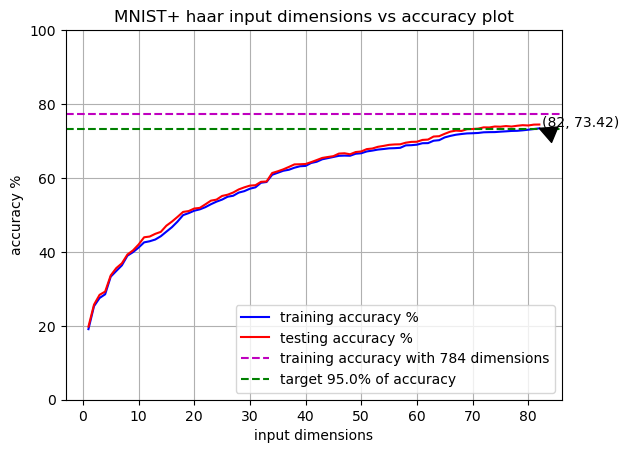

In [111]:
plt.figure()
plt.plot(num_components_history, train_accuracy_history, color='b', label='training accuracy %')
plt.plot(num_components_history, test_accuracy_history, color='r', label='testing accuracy %')
plt.grid(';')
plt.xlabel('input dimensions')
plt.ylabel('accuracy %')
plt.axhline(peak_accuracy, color='m', linestyle='--', label='training accuracy with 784 dimensions')
plt.axhline(target_accuracy, color='g', linestyle='--', label=f'target {100*goal}% of accuracy')
last_point = (num_components_history[-1], train_accuracy_history[-1])
# Annotate the last point
plt.annotate(f'({num_components_history[-1]}, {round(train_accuracy_history[-1],2)})', xy=last_point, xytext=(last_point[0]+0.5, last_point[1]+0.5), arrowprops=dict(facecolor='black', shrink=0.05))
plt.ylim([0,100])
plt.title(f'{tag_name}+ haar input dimensions vs accuracy plot')
plt.legend()

# save the graph
fig_fname = f'haar_' + tag_name + fn_time_string + "_accuracy_vs_dim.jpg" 
fig_fname_abs_path = os.path.join(img_dir_abs_path,fig_fname)
plt.savefig(fig_fname_abs_path,format='jpg',bbox_inches='tight')
plt.show()